In [27]:
import pandas as pd
import yfinance as yf
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import json
import torch
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
from keras import regularizers
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

import itertools
import torch
import statsmodels.api as sm
import matplotlib.pyplot as plt
import torch.nn.functional as F
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error,mean_squared_log_error
from torch import nn
%matplotlib inline
from torch.autograd import Variable
from torch.utils.data import Dataset,DataLoader,TensorDataset
from sklearn.preprocessing import MinMaxScaler

from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
from keras import regularizers

from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
# Load the file
file_path = "stock_datasets/AZN.xlsx"
stock_name = "AZN"
if file_path.endswith('.csv'):
    news_df = pd.read_csv(file_path)
elif file_path.endswith('.xlsx'):
    news_df = pd.read_excel(file_path)
else:
    raise ValueError("Unsupported file format. Please provide a CSV or XLSX file.")

# Remove rows where the 'Time' column has invalid dates
news_df['Time'] = pd.to_datetime(news_df['Time'], errors='coerce')  # Convert invalid dates to NaT
news_df = news_df.dropna(subset=['Time'])  # Drop rows with NaT in 'Time'

# Display the cleaned DataFrame
print(news_df)

                                                 Title       Time  \
1    Astrazeneca receives Investment Bank Analyst R... 2024-07-02   
2    AstraZeneca disappointed with failure of immun... 2024-06-25   
3    Farxiga gains FDA nod for pediatric type-2 dia... 2024-06-12   
4    Astrazeneca receives Investment Bank Analyst R... 2024-06-10   
5    Astrazeneca receives Investment Bank Analyst R... 2024-06-05   
..                                                 ...        ...   
995  AstraZeneca sought to buy Japan's Daiichi Sank... 2017-08-31   
996  Sweden shares higher at close of trade; OMX St... 2017-08-30   
997  AstraZeneca taps AI for drug discovery in deal... 2017-08-28   
998                    FTSE 100 ends flat as WPP sinks 2017-08-23   
999  FDA expands use of AstraZeneca/Merck ovarian c... 2017-08-17   

                                                 Like1  
1                                                  NaN  
2    Proactive Investors - AstraZeneca PLC (LON:AZN...  


In [28]:
# Sort the DataFrame by 'Time'
news_df_sorted = news_df.sort_values(by='Time')

# Remove duplicate rows and select only 'Title' and 'Time' columns
news_df_cleaned = news_df_sorted[['Title', 'Time']].drop_duplicates()

# Rename the 'Time' column to 'Date'
news_df_cleaned = news_df_cleaned.rename(columns={'Time': 'Date'})

# Optionally, reset the index after removing duplicates
news_df_cleaned = news_df_cleaned.reset_index(drop=True)

# Save the cleaned data as JSON
news_df_cleaned.to_json(f"news_title/{stock_name}_news_title.json", orient='records', lines=True)

# Display the cleaned DataFrame
news_df_cleaned.tail()


,Title,Date
963,Astrazeneca receives Investment Bank Analyst R...,2024-06-05
964,Astrazeneca receives Investment Bank Analyst R...,2024-06-10
965,Farxiga gains FDA nod for pediatric type-2 dia...,2024-06-12
966,AstraZeneca disappointed with failure of immun...,2024-06-25
967,Astrazeneca receives Investment Bank Analyst R...,2024-07-02


In [29]:
# Determine the start and end dates from the news data
start_date = news_df_cleaned['Date'].min().strftime('%Y-%m-%d')
end_date = news_df_cleaned['Date'].max().strftime('%Y-%m-%d')

# Download historical data for AstraZeneca (AZN) based on the date range from the news data
stock_data = yf.download(stock_name, start=start_date, end=end_date)

# Display the first few rows of the data
print(stock_data.head())
print(stock_data.tail())

[*********************100%%**********************]  1 of 1 completed

                 Open       High        Low      Close  Adj Close   Volume
Date                                                                      
2017-08-17  29.490000  29.559999  29.049999  29.080000  23.963928  4612300
2017-08-18  29.090000  29.160000  28.879999  29.120001  23.996889  4184900
2017-08-21  29.049999  29.049999  28.780001  28.959999  23.865036  3237900
2017-08-22  28.870001  29.129999  28.840000  29.070000  23.955683  3469800
2017-08-23  29.240000  29.320000  29.080000  29.139999  24.013369  2443300
                 Open       High        Low      Close  Adj Close   Volume
Date                                                                      
2024-06-25  79.589996  79.870003  79.440002  79.750000  79.262825  3081700
2024-06-26  79.160004  79.620003  78.910004  79.080002  78.596924  3227800
2024-06-27  79.089996  79.160004  77.949997  78.180000  77.702415  2796600
2024-06-28  78.629997  78.750000  77.830002  77.989998  77.513573  3664400
2024-07-01  77.709999  78

In [30]:
modelName = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(modelName)
model = AutoModelForSequenceClassification.from_pretrained(modelName)
def calculateDailySentiment(headlines):
    texts = [headline['heading'] for headline in headlines]
    inputs = tokenizer(texts, return_tensors="pt", truncation=True, padding=True, max_length=512, return_attention_mask=True)
    outputs = model(**inputs)
    logits = outputs.logits
    scores = logits.softmax(dim=1)
    averageScore = scores.mean(dim=0).tolist()
    return averageScore
#enddef


def analyzeAndSaveSentiment(inputFile, outputFile):
    result = {}
    
    # Open the file and process each line as a separate JSON object
    with open(inputFile, 'r',  encoding="utf8") as file:
        for line in file:
            # Parse each line (record) as a separate JSON object
            record = json.loads(line)
            date = record.get('Date')
            title = record.get('Title')

            if date and title:
                # Convert the timestamp to a readable date
                readable_date = datetime.fromtimestamp(int(date) / 1000).strftime('%Y-%m-%d')
                
                # Prepare the headlines in the required format
                headlines = [{'heading': title}]
                averageScore = calculateDailySentiment(headlines)
                print(f"{readable_date} > {averageScore}")
                result[readable_date] = averageScore
            #endif
        #endfor
    #endwith

    # Write the result to an output file
    with open(outputFile, 'w', encoding="utf8") as outFile:
        json.dump(result, outFile, indent=2)
    #endwith
#enddef

In [31]:
inputJsonFile = f"news_title/{stock_name}_news_title.json"
outputJsonFile = f"sentiment_score/{stock_name}_news_sentiment_score.json"

analyzeAndSaveSentiment(inputJsonFile, outputJsonFile)

2017-08-17 > [0.22176584601402283, 0.1579236090183258, 0.19072778522968292, 0.22798366844654083, 0.2015991508960724]
2017-08-23 > [0.4281363785266876, 0.31938308477401733, 0.18469460308551788, 0.04444992542266846, 0.02333597093820572]
2017-08-28 > [0.04979458078742027, 0.04702885448932648, 0.11244329810142517, 0.31356245279312134, 0.47717079520225525]
2017-08-30 > [0.4443873167037964, 0.3131257891654968, 0.169906347990036, 0.041613392531871796, 0.030967116355895996]
2017-08-31 > [0.6805555820465088, 0.18247652053833008, 0.09756118804216385, 0.02576659433543682, 0.013640046119689941]
2017-08-31 > [0.4021134376525879, 0.19810858368873596, 0.15937982499599457, 0.11920907348394394, 0.12118910998106003]
2017-09-01 > [0.40322643518447876, 0.33608192205429077, 0.19173580408096313, 0.04136671870946884, 0.027589209377765656]
2017-09-06 > [0.44012609124183655, 0.37355220317840576, 0.15587615966796875, 0.020766736939549446, 0.009678863920271397]
2017-09-06 > [0.008870352990925312, 0.0129924314096

2018-02-05 > [0.5188519358634949, 0.3232174813747406, 0.12669746577739716, 0.019964806735515594, 0.011268250644207]
2018-02-07 > [0.1558583527803421, 0.15295451879501343, 0.23476456105709076, 0.24885879456996918, 0.20756377279758453]
2018-02-08 > [0.27088046073913574, 0.3401501178741455, 0.27200397849082947, 0.08312232792377472, 0.033843137323856354]
2018-02-08 > [0.4450373649597168, 0.38062429428100586, 0.14808672666549683, 0.017914287745952606, 0.008337322622537613]
2018-02-09 > [0.4446312487125397, 0.37366488575935364, 0.1523333042860031, 0.019733276218175888, 0.009637323208153248]
2018-02-13 > [0.05246896296739578, 0.05331749469041824, 0.11608127504587173, 0.2798900902271271, 0.49824219942092896]
2018-02-15 > [0.40806782245635986, 0.3326982259750366, 0.1886143982410431, 0.0418902225792408, 0.02872936986386776]
2018-02-15 > [0.022660009562969208, 0.03738513961434364, 0.1338193118572235, 0.3791412115097046, 0.42699435353279114]
2018-02-16 > [0.20799849927425385, 0.1499982625246048, 0

2018-08-22 > [0.366335391998291, 0.3631589710712433, 0.2038387507200241, 0.04684315621852875, 0.01982376165688038]
2018-09-06 > [0.21057549118995667, 0.17413952946662903, 0.21725524961948395, 0.2181806117296219, 0.17984910309314728]
2018-09-07 > [0.02758079208433628, 0.028085559606552124, 0.07713282108306885, 0.3210570812225342, 0.5461437106132507]
2018-09-12 > [0.46510082483291626, 0.3683944344520569, 0.14081105589866638, 0.01745598390698433, 0.008237546309828758]
2018-09-13 > [0.3998052775859833, 0.3368782103061676, 0.1942523568868637, 0.041812464594841, 0.02725169248878956]
2018-09-19 > [0.2649257183074951, 0.19404736161231995, 0.19267740845680237, 0.19453264772891998, 0.15381678938865662]
2018-09-25 > [0.4193780720233917, 0.3384842276573181, 0.1795591115951538, 0.037463534623384476, 0.025115035474300385]
2018-09-26 > [0.4193780720233917, 0.3384842276573181, 0.1795591115951538, 0.037463534623384476, 0.025115035474300385]
2018-09-27 > [0.37165194749832153, 0.31941166520118713, 0.2031

2019-05-23 > [0.5203351378440857, 0.32186317443847656, 0.12666185200214386, 0.019920457154512405, 0.01121941301971674]
2019-07-03 > [0.28232061862945557, 0.2076597958803177, 0.15892356634140015, 0.1242818832397461, 0.22681421041488647]
2019-07-12 > [0.5263713598251343, 0.2622096538543701, 0.14197313785552979, 0.04183165356516838, 0.027614112943410873]
2019-07-17 > [0.16674897074699402, 0.23645569384098053, 0.2550993263721466, 0.20524480938911438, 0.13645119965076447]
2019-07-17 > [0.13597220182418823, 0.10283426195383072, 0.16606830060482025, 0.27618712186813354, 0.31893813610076904]
2019-07-24 > [0.39858728647232056, 0.20101937651634216, 0.20910227298736572, 0.10585273802280426, 0.0854383185505867]
2019-07-24 > [0.33037710189819336, 0.325711190700531, 0.22690267860889435, 0.08290190249681473, 0.03410705178976059]
2019-07-25 > [0.5508526563644409, 0.30460378527641296, 0.11706597357988358, 0.017858223989605904, 0.009619398973882198]
2019-07-25 > [0.25753793120384216, 0.2250358611345291,

2020-01-27 > [0.4230453073978424, 0.16313599050045013, 0.13064195215702057, 0.10802970081567764, 0.17514698207378387]
2020-02-13 > [0.28325751423835754, 0.1916598081588745, 0.15867190062999725, 0.1551114171743393, 0.21129940450191498]
2020-02-14 > [0.11480843275785446, 0.34563544392585754, 0.382535845041275, 0.11088457703590393, 0.04613569751381874]
2020-02-14 > [0.004750765860080719, 0.0023536384105682373, 0.00728744687512517, 0.036250606179237366, 0.9493575692176819]
2020-02-14 > [0.3501114547252655, 0.17266714572906494, 0.19386644661426544, 0.14438705146312714, 0.1389678716659546]
2020-02-14 > [0.36593541502952576, 0.22058039903640747, 0.19409172236919403, 0.08793047070503235, 0.1314619779586792]
2020-02-14 > [0.5510981678962708, 0.30406510829925537, 0.11736615747213364, 0.017985722050070763, 0.009484858252108097]
2020-02-14 > [0.47926774621009827, 0.2819916903972626, 0.15192092955112457, 0.05636387690901756, 0.030455773696303368]
2020-04-14 > [0.2399340718984604, 0.3037477433681488

2020-07-05 > [0.44696730375289917, 0.1954360157251358, 0.1563902497291565, 0.10116903483867645, 0.10003748536109924]
2020-07-06 > [0.17645998299121857, 0.11829444766044617, 0.152899369597435, 0.22928206622600555, 0.32306405901908875]
2020-07-08 > [0.15094545483589172, 0.10934880375862122, 0.16386672854423523, 0.25466468930244446, 0.3211743235588074]
2020-07-08 > [0.22929449379444122, 0.12946297228336334, 0.1806947886943817, 0.22857660055160522, 0.23197118937969208]
2020-07-15 > [0.33041635155677795, 0.18720248341560364, 0.16960319876670837, 0.15986602008342743, 0.15291187167167664]
2020-07-15 > [0.39017364382743835, 0.2522888481616974, 0.1826142966747284, 0.11049521714448929, 0.06442790478467941]
2020-07-17 > [0.5031895041465759, 0.28075307607650757, 0.15014156699180603, 0.03666141629219055, 0.029254456982016563]
2020-07-20 > [0.17958106100559235, 0.31717002391815186, 0.33610817790031433, 0.11164017021656036, 0.0555005744099617]
2020-07-20 > [0.27746346592903137, 0.14300870895385742, 0

2020-09-08 > [0.3038725256919861, 0.2746363580226898, 0.22672110795974731, 0.13224279880523682, 0.06252717226743698]
2020-09-09 > [0.7235680818557739, 0.2019549012184143, 0.06206461042165756, 0.008559104055166245, 0.0038532887119799852]
2020-09-09 > [0.3362326920032501, 0.3278536796569824, 0.19133247435092926, 0.08540134131908417, 0.05917991325259209]
2020-09-09 > [0.2651703655719757, 0.3205425441265106, 0.28491124510765076, 0.09940677136182785, 0.02996906265616417]
2020-09-09 > [0.005072818603366613, 0.002520729089155793, 0.0068018026649951935, 0.03201965242624283, 0.9535849690437317]
2020-09-09 > [0.15369531512260437, 0.4002428352832794, 0.35505184531211853, 0.06988148391246796, 0.021128538995981216]
2020-09-09 > [0.22885656356811523, 0.30351123213768005, 0.33496877551078796, 0.10903196036815643, 0.023631475865840912]
2020-09-09 > [0.4549180567264557, 0.29189056158065796, 0.15825387835502625, 0.057311709970235825, 0.037625834345817566]
2020-09-09 > [0.04956483468413353, 0.05520802363

2020-10-26 > [0.3393588364124298, 0.30677157640457153, 0.2369305044412613, 0.07911813259124756, 0.03782091662287712]
2020-10-28 > [0.4354531466960907, 0.22671659290790558, 0.16901259124279022, 0.09442489594221115, 0.07439271360635757]
2020-10-29 > [0.15926538407802582, 0.12446486204862595, 0.18562333285808563, 0.2507036626338959, 0.27994269132614136]
2020-10-30 > [0.14626702666282654, 0.12064263224601746, 0.18674060702323914, 0.25236865878105164, 0.29398107528686523]
2020-10-30 > [0.5755382180213928, 0.1650664508342743, 0.10654482990503311, 0.06787708401679993, 0.08497339487075806]
2020-11-02 > [0.1269414722919464, 0.12556734681129456, 0.2020673006772995, 0.2580455541610718, 0.2873784005641937]
2020-11-04 > [0.4519306421279907, 0.2892736494541168, 0.1662113219499588, 0.04849986359477043, 0.044084638357162476]
2020-11-04 > [0.06579869240522385, 0.060269810259342194, 0.1703367829322815, 0.29252561926841736, 0.41106903553009033]
2020-11-04 > [0.032820187509059906, 0.04099353030323982, 0.1

2021-03-15 > [0.4296724200248718, 0.36787325143814087, 0.130165696144104, 0.03781077638268471, 0.03447781130671501]
2021-03-16 > [0.0330716073513031, 0.0319674015045166, 0.08108025789260864, 0.2998653054237366, 0.5540154576301575]
2021-03-16 > [0.10461442917585373, 0.31040483713150024, 0.361370712518692, 0.16436877846717834, 0.059241294860839844]
2021-03-16 > [0.3660309612751007, 0.41753584146499634, 0.17617642879486084, 0.02598697692155838, 0.014269816689193249]
2021-03-17 > [0.013308183290064335, 0.022061729803681374, 0.09498991072177887, 0.3768886923789978, 0.4927515387535095]
2021-03-18 > [0.23356060683727264, 0.1523062139749527, 0.17485696077346802, 0.20259590446949005, 0.23668032884597778]
2021-03-22 > [0.024876127019524574, 0.029881708323955536, 0.11406005918979645, 0.31631603837013245, 0.5148659944534302]
2021-03-22 > [0.3645152449607849, 0.29009419679641724, 0.18663237988948822, 0.09300176054239273, 0.06575649231672287]
2021-03-23 > [0.18304947018623352, 0.14876578748226166, 0

2021-12-07 > [0.09087062627077103, 0.15976956486701965, 0.26002782583236694, 0.29626426100730896, 0.19306765496730804]
2021-12-09 > [0.05686873570084572, 0.08214657753705978, 0.15228904783725739, 0.309198796749115, 0.39949682354927063]
2021-12-10 > [0.07538726925849915, 0.053869232535362244, 0.10298460721969604, 0.2734816074371338, 0.49427732825279236]
2021-12-14 > [0.0522758811712265, 0.0615859217941761, 0.12566135823726654, 0.3181256055831909, 0.44235122203826904]
2021-12-15 > [0.4220929741859436, 0.1998768150806427, 0.14199018478393555, 0.10069523006677628, 0.13534487783908844]
2021-12-15 > [0.6106376051902771, 0.17957673966884613, 0.09373527765274048, 0.05758749321103096, 0.05846288427710533]
2021-12-16 > [0.4832906424999237, 0.26251643896102905, 0.15685684978961945, 0.06527455896139145, 0.03206152468919754]
2021-12-16 > [0.02005966752767563, 0.09217789769172668, 0.45678848028182983, 0.36432749032974243, 0.06664638966321945]
2021-12-20 > [0.11622095853090286, 0.12818363308906555, 0

2022-07-29 > [0.04325918108224869, 0.05646056309342384, 0.165568545460701, 0.359772652387619, 0.37493905425071716]
2022-07-29 > [0.08027598261833191, 0.08609376847743988, 0.1657147854566574, 0.28548550605773926, 0.38242992758750916]
2022-08-01 > [0.10005156695842743, 0.10639078915119171, 0.15396881103515625, 0.29083552956581116, 0.34875330328941345]
2022-08-01 > [0.3991412818431854, 0.1682281792163849, 0.20065435767173767, 0.1261916607618332, 0.10578444600105286]
2022-08-01 > [0.16433949768543243, 0.1464236080646515, 0.17514726519584656, 0.28458645939826965, 0.22950315475463867]
2022-08-04 > [0.417794406414032, 0.21439146995544434, 0.19052453339099884, 0.11469963937997818, 0.06258995831012726]
2022-08-04 > [0.34533196687698364, 0.16652129590511322, 0.21908165514469147, 0.1553543508052826, 0.11371075361967087]
2022-08-04 > [0.3991412818431854, 0.1682281792163849, 0.20065435767173767, 0.1261916607618332, 0.10578444600105286]
2022-08-05 > [0.3991412818431854, 0.1682281792163849, 0.2006543

2023-02-03 > [0.0017552828649058938, 0.0013532042503356934, 0.004214422777295113, 0.04778952896595001, 0.9448875784873962]
2023-02-08 > [0.05512310937047005, 0.05283535644412041, 0.16558575630187988, 0.29358971118927, 0.43286603689193726]
2023-02-08 > [0.29188719391822815, 0.2274605631828308, 0.1999429166316986, 0.13755184412002563, 0.14315740764141083]
2023-02-09 > [0.1662508249282837, 0.42926955223083496, 0.34032055735588074, 0.0484764501452446, 0.01568262279033661]
2023-02-09 > [0.13766717910766602, 0.22625136375427246, 0.3023233413696289, 0.22156734764575958, 0.112190842628479]
2023-02-09 > [0.33874231576919556, 0.24150116741657257, 0.21117720007896423, 0.1170036569237709, 0.09157565981149673]
2023-02-09 > [0.39246535301208496, 0.26108717918395996, 0.14850690960884094, 0.08493640273809433, 0.11300409585237503]
2023-02-09 > [0.027572011575102806, 0.04499487206339836, 0.11468346416950226, 0.3302307426929474, 0.48251888155937195]
2023-02-09 > [0.12800700962543488, 0.20750010013580322,

2023-07-05 > [0.34533196687698364, 0.16652129590511322, 0.21908165514469147, 0.1553543508052826, 0.11371075361967087]
2023-07-12 > [0.34533196687698364, 0.16652129590511322, 0.21908165514469147, 0.1553543508052826, 0.11371075361967087]
2023-07-13 > [0.34533196687698364, 0.16652129590511322, 0.21908165514469147, 0.1553543508052826, 0.11371075361967087]
2023-07-14 > [0.34533196687698364, 0.16652129590511322, 0.21908165514469147, 0.1553543508052826, 0.11371075361967087]
2023-07-14 > [0.34533196687698364, 0.16652129590511322, 0.21908165514469147, 0.1553543508052826, 0.11371075361967087]
2023-07-28 > [0.3087656497955322, 0.25281623005867004, 0.24188287556171417, 0.12511344254016876, 0.07142183184623718]
2023-08-07 > [0.34533196687698364, 0.16652129590511322, 0.21908165514469147, 0.1553543508052826, 0.11371075361967087]
2023-08-18 > [0.6210575103759766, 0.2957288324832916, 0.07494945079088211, 0.005806361325085163, 0.0024578566662967205]
2023-08-23 > [0.4371819496154785, 0.23780043423175812,

2024-02-08 > [0.4828447699546814, 0.29120486974716187, 0.15152163803577423, 0.0422401949763298, 0.03218856081366539]
2024-02-08 > [0.7116997838020325, 0.17007771134376526, 0.08052022755146027, 0.02116372622549534, 0.016538528725504875]
2024-02-08 > [0.37343233823776245, 0.43565720319747925, 0.15745200216770172, 0.022826237604022026, 0.010632273741066456]
2024-02-09 > [0.04757240414619446, 0.05961329862475395, 0.1513928472995758, 0.3889515995979309, 0.35246992111206055]
2024-02-09 > [0.34533196687698364, 0.16652129590511322, 0.21908165514469147, 0.1553543508052826, 0.11371075361967087]
2024-02-12 > [0.34533196687698364, 0.16652129590511322, 0.21908165514469147, 0.1553543508052826, 0.11371075361967087]
2024-02-13 > [0.3531334102153778, 0.3009447157382965, 0.22897517681121826, 0.07126293331384659, 0.04568380117416382]
2024-02-15 > [0.34533196687698364, 0.16652129590511322, 0.21908165514469147, 0.1553543508052826, 0.11371075361967087]
2024-02-19 > [0.049699537456035614, 0.04698117449879646

In [32]:
# Load the sentiment scores from the JSON file
with open(f"sentiment_score/{stock_name}_news_sentiment_score.json", 'r') as f:
    sentiment_data = json.load(f)

# Create a DataFrame to store the sentiment scores without averaging them
processed_data = {
    'Date': [],
    'SentimentScores': []
}

# Iterate through the JSON data and append the sentiment scores for each date
for date, scores in sentiment_data.items():
    processed_data['Date'].append(date)
    processed_data['SentimentScores'].append(scores)  # Keep the list of sentiment scores

# Convert processed data to a DataFrame
news_sentiment_df = pd.DataFrame(processed_data)

# Ensure the 'Date' column is in datetime format
news_sentiment_df['Date'] = pd.to_datetime(news_sentiment_df['Date'])

# Display the DataFrame
news_sentiment_df


,Date,SentimentScores
0,2017-08-17,"[0.22176584601402283, 0.1579236090183258, 0.19..."
1,2017-08-23,"[0.4281363785266876, 0.31938308477401733, 0.18..."
2,2017-08-28,"[0.04979458078742027, 0.04702885448932648, 0.1..."
3,2017-08-30,"[0.4443873167037964, 0.3131257891654968, 0.169..."
4,2017-08-31,"[0.4021134376525879, 0.19810858368873596, 0.15..."
...,...,...
601,2024-06-05,"[0.34533196687698364, 0.16652129590511322, 0.2..."
602,2024-06-10,"[0.34533196687698364, 0.16652129590511322, 0.2..."
603,2024-06-12,"[0.38033124804496765, 0.28673049807548523, 0.2..."
604,2024-06-25,"[0.3720051348209381, 0.4703655242919922, 0.145..."


In [33]:
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-08-17,29.490000,29.559999,29.049999,29.080000,23.963928,4612300
2017-08-18,29.090000,29.160000,28.879999,29.120001,23.996889,4184900
2017-08-21,29.049999,29.049999,28.780001,28.959999,23.865036,3237900
2017-08-22,28.870001,29.129999,28.840000,29.070000,23.955683,3469800
2017-08-23,29.240000,29.320000,29.080000,29.139999,24.013369,2443300
...,...,...,...,...,...,...
2024-06-25,79.589996,79.870003,79.440002,79.750000,79.262825,3081700
2024-06-26,79.160004,79.620003,78.910004,79.080002,78.596924,3227800
2024-06-27,79.089996,79.160004,77.949997,78.180000,77.702415,2796600


In [34]:
news_sentiment_df.head()

,Date,SentimentScores
0,2017-08-17,"[0.22176584601402283, 0.1579236090183258, 0.19..."
1,2017-08-23,"[0.4281363785266876, 0.31938308477401733, 0.18..."
2,2017-08-28,"[0.04979458078742027, 0.04702885448932648, 0.1..."
3,2017-08-30,"[0.4443873167037964, 0.3131257891654968, 0.169..."
4,2017-08-31,"[0.4021134376525879, 0.19810858368873596, 0.15..."


In [35]:
# Merge the two DataFrames on the 'Date' column
dfMerged = pd.merge(stock_data, news_sentiment_df, on='Date', how='left')

# Check if each element in 'SentimentScores' is a list, and replace invalid ones with NaN or an empty list
dfMerged['SentimentScores'] = dfMerged['SentimentScores'].apply(lambda x: x if isinstance(x, list) else [None] * 5)

# Ensure each list in 'SentimentScores' has 5 elements (or adjust this if your data varies)
dfMerged['SentimentScores'] = dfMerged['SentimentScores'].apply(lambda x: x if len(x) == 5 else [None] * 5)

# Convert the 'SentimentScores' list into separate columns
dfSentimentColumns = pd.DataFrame(dfMerged['SentimentScores'].tolist(), columns=['feature1', 'feature2', 'feature3', 'feature4', 'feature5'])

# Concatenate the origi|nal DataFrame with the new sentiment columns
dfMerged = pd.concat([dfMerged, dfSentimentColumns], axis=1)

# Drop unnecessary columns
dfMerged = dfMerged.drop(columns=['SentimentScores'])

# Display the merged DataFrame
dfMerged.head()


,Date,Open,High,Low,Close,Adj Close,Volume,feature1,feature2,feature3,feature4,feature5
0,2017-08-17,29.490000,29.559999,29.049999,29.080000,23.963928,4612300,0.221766,0.157924,0.190728,0.227984,0.201599
1,2017-08-18,29.090000,29.160000,28.879999,29.120001,23.996889,4184900,NaN,NaN,NaN,NaN,NaN
2,2017-08-21,29.049999,29.049999,28.780001,28.959999,23.865036,3237900,NaN,NaN,NaN,NaN,NaN
3,2017-08-22,28.870001,29.129999,28.840000,29.070000,23.955683,3469800,NaN,NaN,NaN,NaN,NaN
4,2017-08-23,29.240000,29.320000,29.080000,29.139999,24.013369,2443300,0.428136,0.319383,0.184695,0.044450,0.023336


In [36]:
dfMerged[['feature1', 'feature2','feature3','feature4','feature5']] = dfMerged[['feature1', 'feature2','feature3','feature4','feature5']].interpolate(method='linear', axis=0)


Missing values:
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
feature1     0
feature2     0
feature3     0
feature4     0
feature5     0
dtype: int64
Statistical summary:
              Open         High          Low        Close    Adj Close  \
count  1728.000000  1728.000000  1728.000000  1728.000000  1728.000000   
mean     53.202651    53.589242    52.805718    53.200093    49.271903   
std      12.842054    12.926063    12.747822    12.835204    14.244007   
min      28.870001    29.049999    28.780001    28.959999    23.865036   
25%      40.395001    40.884999    40.127501    40.529999    35.381788   
50%      54.300001    54.775000    53.740002    54.199999    49.628651   
75%      64.702497    65.172499    64.160002    64.792501    62.689486   
max      80.629997    80.860001    80.459999    80.830002    80.336227   

             Volume     feature1     feature2     feature3     feature4  \
count  1.728000e+03  1728.00

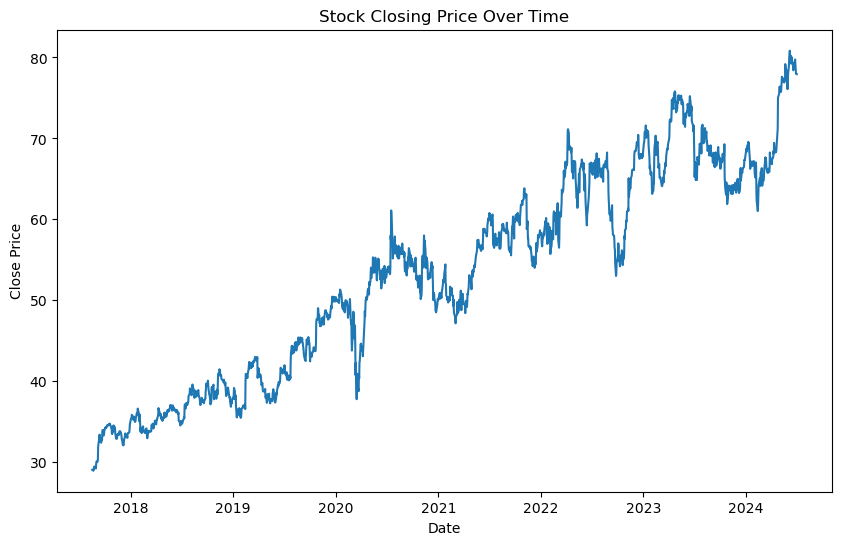

KeyError: "['Very negative', 'Negative', 'Neutral', 'Positive', 'Very Positive'] not in index"

<Figure size 1000x600 with 0 Axes>

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data (Assuming the dataset is already in a DataFrame 'df')
dfMerged['Date'] = pd.to_datetime(dfMerged['Date'])  # Ensure 'Date' is in datetime format

# 1. Check for missing values
print("Missing values:")
print(dfMerged.isnull().sum())

# 2. Statistical summary of numerical columns
print("Statistical summary:")
print(dfMerged.describe())


# 4. Time Series Analysis: Plot stock prices over time (e.g., 'Close' price)
plt.figure(figsize=(10, 6))
plt.plot(dfMerged['Date'], dfMerged['Close'])
plt.title('Stock Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

# 5. Correlation Matrix (Stock Features & Additional Features)
plt.figure(figsize=(10, 6))
correlation_matrix = dfMerged[['Close', 'Very negative', 'Negative', 'Neutral', 'Positive', 'Very Positive']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix for Stock Data and Features')
plt.show()

# 6. Handle Missing Values (if you choose to fill or drop)
df_cleaned = dfMerged.dropna(subset=['Very negative', 'Negative', 'Neutral', 'Positive', 'Very Positive'])  # Drop rows with NaNs in features
# Alternatively, you can fill NaN with a specific value or interpolation (e.g., df['feature1'].fillna(df['feature1'].mean(), inplace=True))



In [37]:
dfMerged

,Date,Open,High,Low,Close,Adj Close,Volume,feature1,feature2,feature3,feature4,feature5
0,2017-08-17,29.490000,29.559999,29.049999,29.080000,23.963928,4612300,0.221766,0.157924,0.190728,0.227984,0.201599
1,2017-08-18,29.090000,29.160000,28.879999,29.120001,23.996889,4184900,0.273358,0.198288,0.189219,0.182100,0.157033
2,2017-08-21,29.049999,29.049999,28.780001,28.959999,23.865036,3237900,0.324951,0.238653,0.187711,0.136217,0.112468
3,2017-08-22,28.870001,29.129999,28.840000,29.070000,23.955683,3469800,0.376544,0.279018,0.186203,0.090333,0.067902
4,2017-08-23,29.240000,29.320000,29.080000,29.139999,24.013369,2443300,0.428136,0.319383,0.184695,0.044450,0.023336
...,...,...,...,...,...,...,...,...,...,...,...,...
1723,2024-06-25,79.589996,79.870003,79.440002,79.750000,79.262825,3081700,0.372005,0.470366,0.145243,0.010220,0.002166
1724,2024-06-26,79.160004,79.620003,78.910004,79.080002,78.596924,3227800,0.372005,0.470366,0.145243,0.010220,0.002166
1725,2024-06-27,79.089996,79.160004,77.949997,78.180000,77.702415,2796600,0.372005,0.470366,0.145243,0.010220,0.002166
1726,2024-06-28,78.629997,78.750000,77.830002,77.989998,77.513573,3664400,0.372005,0.470366,0.145243,0.010220,0.002166


In [38]:
def createDataset(dataset, target, lookBack=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - lookBack):
        a = dataset[i:(i + lookBack), :]
        dataX.append(a)
        dataY.append(target[i + lookBack])
    return np.array(dataX), np.array(dataY)
#enddef

In [39]:
features = dfMerged.drop(['Date', 'Close'], axis=1).values
target = dfMerged['Close'].values

scalerFeatures = MinMaxScaler(feature_range=(0, 1))
scalerTarget = MinMaxScaler(feature_range=(0, 1))

featuresScaled = scalerFeatures.fit_transform(features)
targetScaled = scalerTarget.fit_transform(target.reshape(-1, 1))

lookBack = 60
X, y = createDataset(featuresScaled, targetScaled, lookBack)
print(X[:2])
print(y[:2])

trainSize = int(len(X) * 0.8)
testSize = len(X) - trainSize
trainX, testX = X[0:trainSize, :], X[trainSize:len(X), :]
trainY, testY = y[0:trainSize], y[trainSize:len(y)]

trainX = np.reshape(trainX, (trainX.shape[0], lookBack, trainX.shape[2]))
testX = np.reshape(testX, (testX.shape[0], lookBack, testX.shape[2]))

print(testSize)

[[[0.01197834 0.00984366 0.00522443 ... 0.41211678 0.3575607  0.20888721]
  [0.00425037 0.00212315 0.00193496 ... 0.40878407 0.28422715 0.16225586]
  [0.00347756 0.         0.         ... 0.40545137 0.21089359 0.1156245 ]
  ...
  [0.09157651 0.08975104 0.0890093  ... 0.33636002 0.02572724 0.00782228]
  [0.08442815 0.08415365 0.08301082 ... 0.33241032 0.59026508 0.3871508 ]
  [0.08539413 0.08241653 0.08030185 ... 0.72305872 0.08964588 0.01684432]]

 [[0.00425037 0.00212315 0.00193496 ... 0.40878407 0.28422715 0.16225586]
  [0.00347756 0.         0.         ... 0.40545137 0.21089359 0.1156245 ]
  [0.         0.0015441  0.00116098 ... 0.40211867 0.13756003 0.06899315]
  ...
  [0.08442815 0.08415365 0.08301082 ... 0.33241032 0.59026508 0.3871508 ]
  [0.08539413 0.08241653 0.08030185 ... 0.72305872 0.08964588 0.01684432]
  [0.07380213 0.07817022 0.07410991 ... 0.46179228 0.05023201 0.00965337]]]
[[0.07615193]
 [0.07615193]]
334


In [40]:
batchSize = 8
epoch = 88
neurons = 135
dropout = 0.15

model = Sequential()
model.add(LSTM(neurons, return_sequences=True, activation='tanh', input_shape=(lookBack, features.shape[1])))
model.add(Dropout(dropout))
model.add(LSTM(neurons, return_sequences=True, activation='tanh'))
model.add(Dropout(dropout))
model.add(LSTM(neurons, activation='tanh'))
model.add(Dropout(dropout))

model.add(Dense(units=1, activation='linear', activity_regularizer=regularizers.l1(0.00001)))
#model.add(Activation('tanh'))
model.summary()

model.compile(loss='mean_squared_error' , optimizer='RMSprop')

model.fit(trainX, trainY, epochs=epoch, batch_size=batchSize, verbose=1, validation_split=0.2)

C:\Users\will\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 60, 135)        │        78,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 60, 135)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 60, 135)        │       146,340 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 135)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 135)            │       146,340 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 135)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 371,656 (1.42 MB)

 Trainable params: 371,656 (1.42 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/88
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - loss: 0.0202 - val_loss: 0.0081
Epoch 2/88
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.0047 - val_loss: 0.0033
Epoch 3/88
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.0024 - val_loss: 0.0127
Epoch 4/88
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0026 - val_loss: 0.0229
Epoch 5/88
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.0022 - val_loss: 0.0028
Epoch 6/88
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 7/88
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0018 - val_loss: 0.0024
Epoch 8/88
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 9/88
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 10/88
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 11/88
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.0014 - val_loss: 0.0029
Epoch 12/88
134/134 ━━━━━━━━━━━━━━━━━━━━ 

134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 5.2444e-04 - val_loss: 0.0012
Epoch 67/88
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 5.9878e-04 - val_loss: 8.5458e-04
Epoch 68/88
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 5.3358e-04 - val_loss: 8.6916e-04
Epoch 69/88
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 5.3044e-04 - val_loss: 8.4353e-04
Epoch 70/88
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 5.0498e-04 - val_loss: 0.0012
Epoch 71/88
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 5.7568e-04 - val_loss: 0.0012
Epoch 72/88
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 5.0091e-04 - val_loss: 0.0044
Epoch 73/88
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 6.2667e-04 - val_loss: 8.2065e-04
Epoch 74/88
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 5.8114e-04 - val_loss: 9.4548e-04
Epoch 75/88
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 5.9245e-04 - val_loss: 0.0016
Epoch 76/88
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 4.9580e-04

In [41]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredictInv = scalerTarget.inverse_transform(trainPredict)
trainYInv = scalerTarget.inverse_transform(np.reshape(trainY, (trainY.shape[0], 1)))
testPredictInv = scalerTarget.inverse_transform(testPredict)
testYInv = scalerTarget.inverse_transform(np.reshape(testY, (testY.shape[0], 1)))

42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


In [42]:
trainY

array([[0.07615193],
       [0.07615193],
       [0.08270678],
       ...,
       [0.69828416],
       [0.6988625 ],
       [0.69674181]])

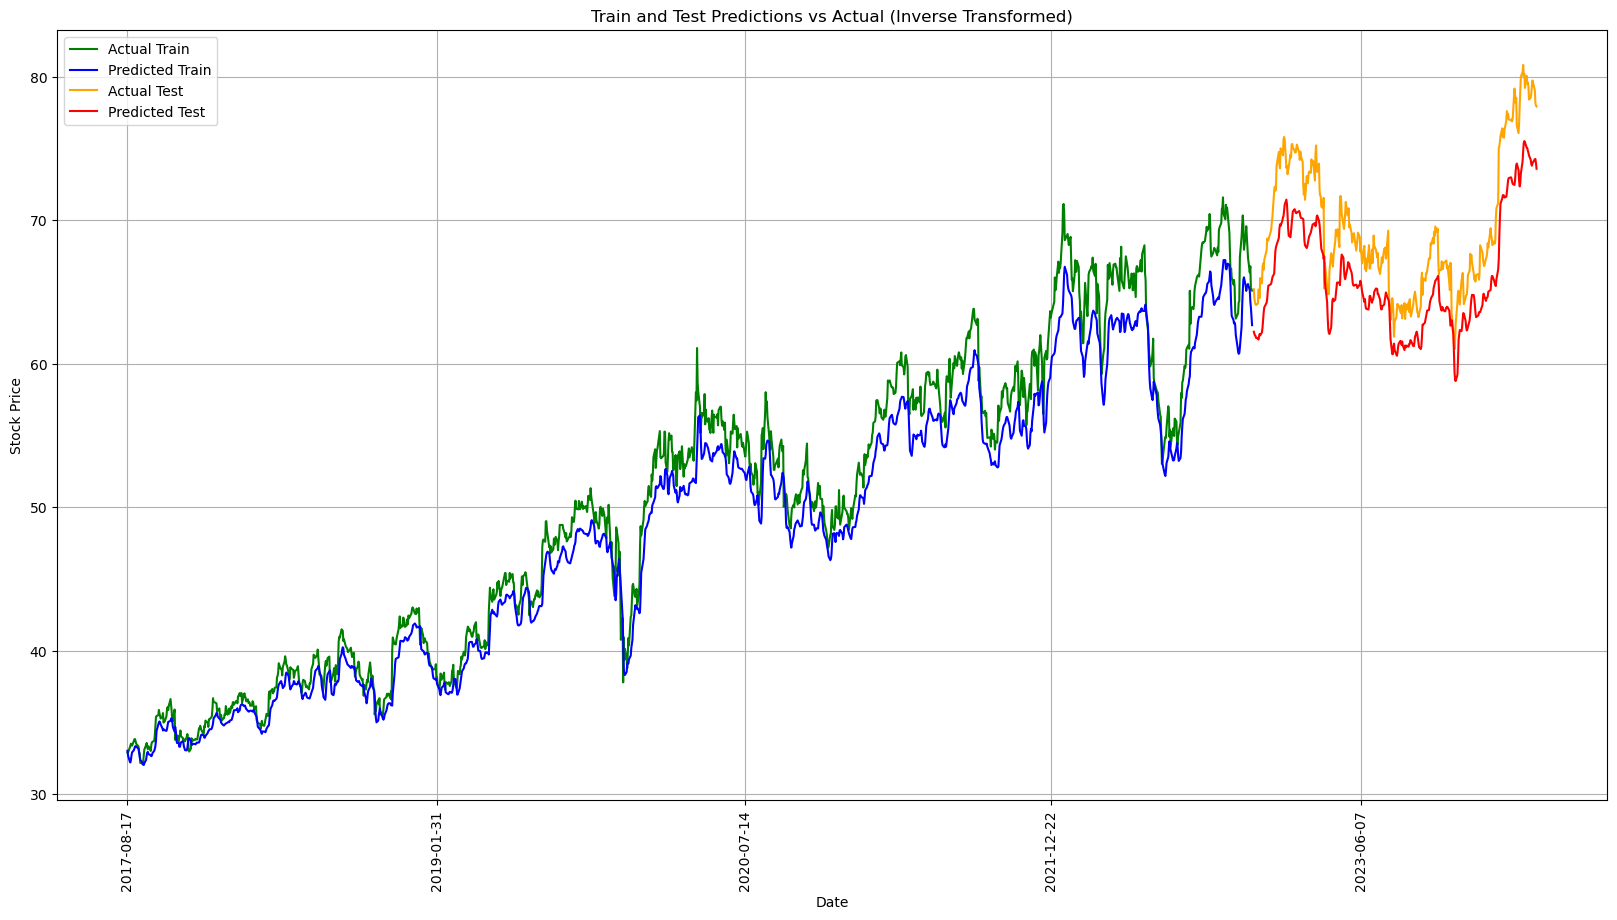

In [43]:
# Dates
dates = dfMerged['Date'].values
sampleInterval = 365  # Interval for sampled x-ticks
sampledDates = dates[::sampleInterval]

# Plot actual and predicted values
plt.figure(figsize=(20, 10))
plt.plot(dates[:len(trainYInv)], trainYInv, label='Actual Train', color='green')
plt.plot(dates[:len(trainPredictInv)], trainPredictInv, label='Predicted Train', color='blue')

plt.plot(dates[len(trainYInv):len(trainYInv) + len(testYInv)], testYInv, label='Actual Test', color='orange')
plt.plot(dates[len(trainYInv):len(trainYInv) + len(testPredictInv)], testPredictInv, label='Predicted Test', color='red')

# X-ticks
plt.xticks(sampledDates, rotation=90)

# Add labels and legend
plt.title('Train and Test Predictions vs Actual (Inverse Transformed)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.show()

Shape of Test Residuals: (334,)
Test Residuals (first 10): [2.96505737 2.48123169 2.31886292 2.17350388 2.30224609 2.41867828
 3.49147797 3.16285324 2.50342178 3.99779129]


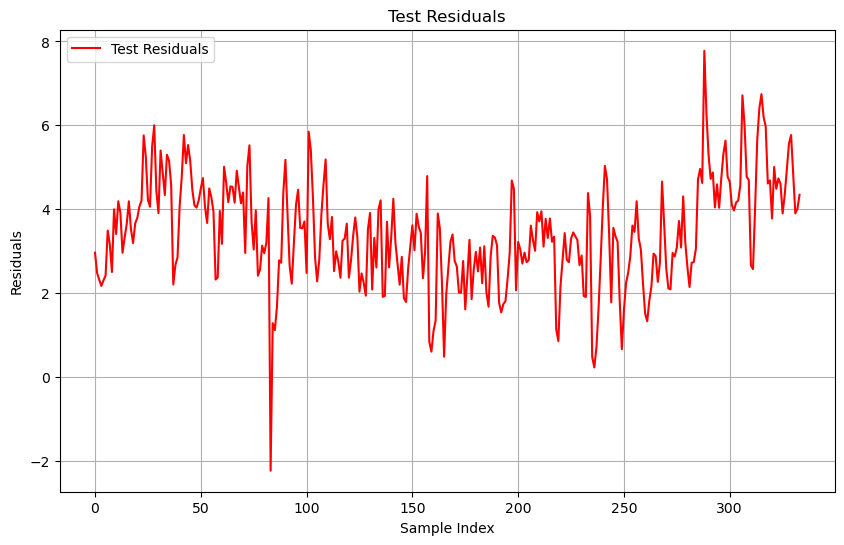

In [54]:
lstm_predictions = testPredictInv[:, 0]

testY = testYInv[:, 0] 

residuals = testY - lstm_predictions

print("Shape of Test Residuals:", residuals.shape)
print("Test Residuals (first 10):", residuals[:10])

plt.figure(figsize=(10, 6))
plt.plot(residuals, label='Test Residuals', color='red')
plt.title('Test Residuals')
plt.xlabel('Sample Index')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)
plt.show()


C:\Users\will\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


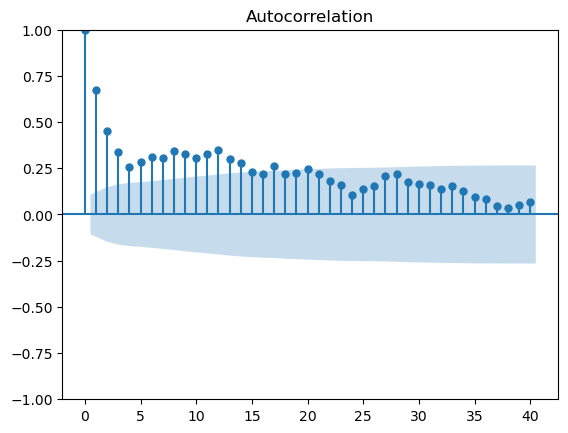

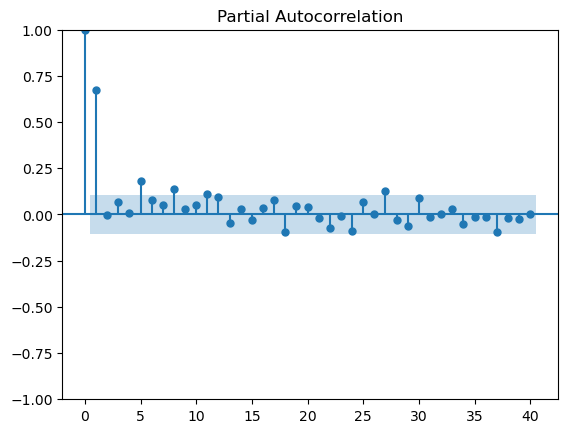

In [45]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Plot ACF and PACF to identify AR and MA orders
sm.graphics.tsa.plot_acf(residuals, lags=40)
sm.graphics.tsa.plot_pacf(residuals, lags=40)
plt.show()

In [55]:
import pmdarima as pm
import numpy as np
# Assuming residuals are univariate, ensure they are in 1D
residuals = residuals.reshape(-1)  # Flatten if necessary

# Fit auto_arima model to search over a very large range
auto_arima_model = pm.auto_arima(residuals, 
                                 p=range(0, 100),    # Search for p values from 0 to 100 (or more)
                                 d=None,             # Let auto_arima detect the order of differencing (d)
                                 q=range(0, 100),    # Search for q values from 0 to 100 (or more)
                                 seasonal=False,
                                 stepwise=True,     
                                 trace=True,         # Show output of model fitting process
                                 error_action='ignore',  # Ignore if an order does not fit
                                 suppress_warnings=True,  # Suppress warnings for cleaner output
                                 maxiter=30)     

# Summary of the chosen ARIMA model
print(auto_arima_model.summary())

# Forecast residuals for the length of the test set
arima_residual_predictions = auto_arima_model.predict(n_periods=len(testY))

# Check the predicted residuals
print(arima_residual_predictions.shape)
print(arima_residual_predictions[:5])


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=898.835, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=964.427, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=957.636, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=950.568, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=962.432, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=897.095, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=902.664, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=898.276, Time=0.17 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=899.061, Time=0.22 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=899.334, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=896.675, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=946.257, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=897.868, Time=0.19 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=943.576, Time=0.06 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=900.2

In [68]:
# Fit ARIMA model to the residuals
import statsmodels.api as sm
arima_model = sm.tsa.arima.ARIMA(residuals, order=(0,0,0))  # Adjust order as needed
arima_fitted = arima_model.fit()

# Predict residuals using ARIMA
arima_residual_predictions = arima_fitted.forecast(steps=len(testX))

In [69]:
hybrid_predictions = lstm_predictions + arima_residual_predictions


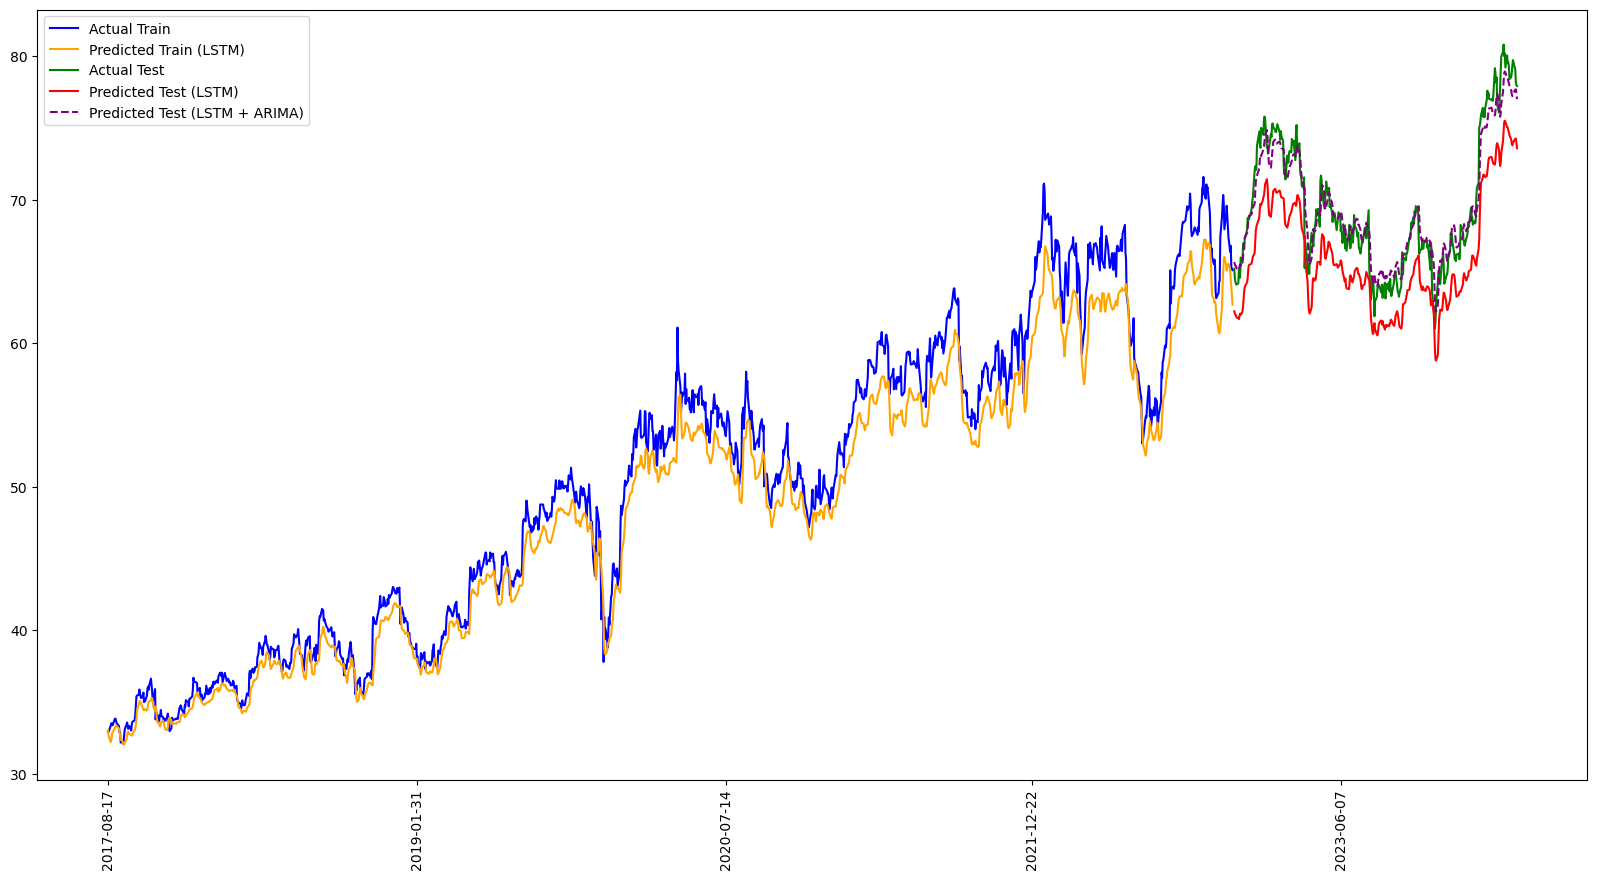

In [70]:

# Extract the dates (already available in your dataframe)
dates = dfMerged['Date'].values

# Sample interval for x-axis
sampleInterval = 365
sampledDates = dates[::sampleInterval]

# Create the plot
plt.figure(figsize=(20, 10))

# Plot actual training values
plt.plot(dates[:len(trainY)], trainYInv, label='Actual Train', color='blue')

# Plot predicted training values (LSTM only)
plt.plot(dates[:len(trainPredictInv)], trainPredictInv, label='Predicted Train (LSTM)', color='orange')

# Plot actual test values
plt.plot(dates[len(trainY):len(trainY) + len(testY)], testYInv, label='Actual Test', color='green')

# Plot predicted test values (LSTM only)
plt.plot(dates[len(trainPredictInv):len(trainPredictInv) + len(testPredictInv)], testPredictInv, label='Predicted Test (LSTM)', color='red')

# Plot predicted test values (LSTM-ARIMA hybrid)
plt.plot(dates[len(trainPredictInv):len(trainPredictInv) + len(hybrid_predictions)], 
         hybrid_predictions, label='Predicted Test (LSTM + ARIMA)', color='purple', linestyle='--')

# Set xticks for the sampled dates
plt.xticks(sampledDates, rotation=90)

# Add legend
plt.legend()

# Show the plot
plt.show()


In [71]:




# Generate hybrid model predictions for training data
hybrid_train_predictions = lstm_predictions

# Calculate metrics for LSTM-only model
mse_lstm = mean_squared_error(testYInv, testPredictInv)
rmse_lstm = np.sqrt(mse_lstm)
mae_lstm = mean_absolute_error(testYInv, testPredictInv)
r2_lstm = r2_score(testYInv, testPredictInv)
mape_lstm = mean_absolute_percentage_error(testYInv, testPredictInv)

# Calculate metrics for LSTM-ARIMA hybrid model
mse_hybrid = mean_squared_error(testYInv, hybrid_predictions)
rmse_hybrid = np.sqrt(mse_hybrid)
mae_hybrid = mean_absolute_error(testYInv, hybrid_predictions)
r2_hybrid = r2_score(testYInv, hybrid_predictions)
mape_hybrid = mean_absolute_percentage_error(testYInv, hybrid_predictions)

# Print the results for LSTM-only model
print(f"LSTM-Only Model Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse_lstm:.5f}")
print(f"Root Mean Squared Error (RMSE): {rmse_lstm:.5f}")
print(f"Mean Absolute Error (MAE): {mae_lstm:.5f}")
print(f"R-squared (R²): {r2_lstm:.5f}")
print(f"Testing Accuracy: {100 - (rmse_lstm / np.mean(testYInv) * 100):.2f}%\n")

# Print the results for LSTM-ARIMA hybrid model
print(f"LSTM-ARIMA Hybrid Model Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse_hybrid:.5f}")
print(f"Root Mean Squared Error (RMSE): {rmse_hybrid:.5f}")
print(f"Mean Absolute Error (MAE): {mae_hybrid:.5f}")
print(f"R-squared (R²): {r2_hybrid:.5f}")
print(f"Testing Accuracy: {100 - (rmse_hybrid / np.mean(testYInv) * 100):.2f}%")


LSTM-Only Model Evaluation Metrics:
Mean Squared Error (MSE): 13.35294
Root Mean Squared Error (RMSE): 3.65417
Mean Absolute Error (MAE): 3.44168
R-squared (R²): 0.40003
Testing Accuracy: 94.74%

LSTM-ARIMA Hybrid Model Evaluation Metrics:
Mean Squared Error (MSE): 1.59962
Root Mean Squared Error (RMSE): 1.26476
Mean Absolute Error (MAE): 0.99852
R-squared (R²): 0.92813
Testing Accuracy: 98.18%


In [51]:


# Ensure the index of stock_data is converted to datetime if not already done
stock_data.index = pd.to_datetime(stock_data.index)

# Reset the index of stock_data to turn 'Date' into a regular column
stock_data = stock_data.reset_index()

# Create a custom business day offset that excludes weekends and US federal holidays
us_business_day = CustomBusinessDay(calendar=USFederalHolidayCalendar())                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

# Assume start_date is the first date in the test set
start_date = stock_data['Date'].iloc[-testSize]  # Assuming `stock_data` contains the full dataset with a 'Date' column

# Generate predicted dates excluding weekends and US federal holidays
predicted_dates = pd.date_range(start=start_date, periods=len(hybrid_predictions), freq=us_business_day)

# Create a DataFrame to save predictions
predictions_df = pd.DataFrame({
    'Date': predicted_dates,
    'Predicted': hybrid_predictions
})

# Save predictions to the 'predictions' directory
predictions_file_path = f"predictions/{stock_name}_hybrid_predictions.csv"
predictions_df.to_csv(predictions_file_path, index=False)

print(f"Predictions saved to '{predictions_file_path}'")


Predictions saved to 'predictions/AZN_hybrid_predictions.csv'


In [52]:
# Create a dictionary with the results
results_dict = {

    "LSTM-ARIMA Hybrid Model": {
        "MSE": mse_hybrid,
        "RMSE": rmse_hybrid,
        "MAE": mae_hybrid,
        "R-squared (R²)": r2_hybrid,
        "Testing Accuracy (%)": 100 - (rmse_hybrid / np.mean(testYInv) * 100)
    }
}

# Generate the file name based on the stock name
file_name = f"model_evaluation/{stock_name}_model_evaluation.json"

# Save the results as a JSON file with the dynamic name
with open(file_name, "w") as f:
    json.dump(results_dict, f, indent=4)

print(f"Results saved as {file_name}")

Results saved as model_evaluation/AZN_model_evaluation.json


In [72]:
import optuna
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import RMSprop

# Function to build the LSTM model
def create_model(neurons, dropout):
    model = Sequential()
    model.add(LSTM(neurons, return_sequences=True, activation='tanh', input_shape=(lookBack, features.shape[1])))
    model.add(Dropout(dropout))
    model.add(LSTM(neurons, return_sequences=True, activation='tanh'))
    model.add(Dropout(dropout))
    model.add(LSTM(neurons, activation='tanh'))
    model.add(Dropout(dropout))
    model.add(Dense(units=1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer=RMSprop())
    return model

# Objective function for optimization
def objective(trial):
    # Suggest hyperparameters
    neurons = trial.suggest_int('neurons', 50, 150)          # Range for neurons
    dropout = trial.suggest_uniform('dropout', 0.1, 0.5)     # Range for dropout
    batch_size = trial.suggest_int('batch_size', 8, 64)      # Range for batch size
    epochs = trial.suggest_int('epochs', 20, 100)            # Range for epochs

    # Create and train the model
    model = create_model(neurons, dropout)
    history = model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0)
    
    # Return validation loss as the metric to minimize
    val_loss = min(history.history['val_loss'])
    return val_loss

# Create study and optimize
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Best parameters found
best_params = study.best_params
print("Best parameters: ", best_params)


[I 2025-01-02 18:11:06,601] A new study created in memory with name: no-name-ce48b85c-84ce-42e5-8538-c5b2ebad66e3
C:\Users\will\AppData\Local\Temp\ipykernel_27560\202567461.py:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.1, 0.5)     # Range for dropout
C:\Users\will\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-01-02 18:13:04,491] Trial 0 finished with value: 0.00153833394870162 and parameters: {'neurons': 76, 'dropout': 0.3579702909909477, 'batch_size': 44, 'epochs': 85}. Best is trial 0 with value: 0.00153833394870162.
[I 2025-01-02 18:13:44,161] Trial 1 finished

[I 2025-01-02 21:25:50,155] Trial 33 finished with value: 0.0007949314313009381 and parameters: {'neurons': 150, 'dropout': 0.12601698253813776, 'batch_size': 13, 'epochs': 88}. Best is trial 32 with value: 0.0007612177287228405.
[I 2025-01-02 21:34:37,130] Trial 34 finished with value: 0.0007970724254846573 and parameters: {'neurons': 140, 'dropout': 0.12645277689032827, 'batch_size': 13, 'epochs': 89}. Best is trial 32 with value: 0.0007612177287228405.
[I 2025-01-02 21:40:37,359] Trial 35 finished with value: 0.0009304463164880872 and parameters: {'neurons': 136, 'dropout': 0.13924185690826787, 'batch_size': 21, 'epochs': 93}. Best is trial 32 with value: 0.0007612177287228405.
[I 2025-01-02 21:47:59,838] Trial 36 finished with value: 0.0008629560470581055 and parameters: {'neurons': 144, 'dropout': 0.15935378127593006, 'batch_size': 16, 'epochs': 87}. Best is trial 32 with value: 0.0007612177287228405.
[I 2025-01-02 21:50:22,305] Trial 37 finished with value: 0.0016559809446334839 

KeyboardInterrupt: 